# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

* В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
* Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
* Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.


## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

    shared/problem1-reg_data.csv – данные о времени регистрации
    shared/problem1-auth_data.csv – данные о времени захода пользователей в игру
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

### Решение:

Импортируем библиотеки (для всех заданий)

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm.auto import tqdm
from scipy.stats import norm

sns.set(rc={'figure.figsize': (11.7, 8.27)})

Прочитаем данные:

In [2]:
reg_df = pd.read_csv('/home/jupyter-r.huretski-16/shared/problem1-reg_data.csv', sep=';')
auth_df = pd.read_csv('/home/jupyter-r.huretski-16/shared/problem1-auth_data.csv', sep=';')

In [69]:
reg_df = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_df = pd.read_csv('problem1-auth_data.csv', sep=';')

In [70]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [71]:
auth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Формат unix epoch неудобен для восприятия, поэтому переведём его в datetime.

In [77]:
reg_df = reg_df.assign(
    reg_dt=pd.to_datetime(reg_df['reg_ts'], unit='s')
)

auth_df = auth_df.assign(
    auth_dt=pd.to_datetime(auth_df['auth_ts'], unit='s')
)

print(f'Registration data "head":\n{reg_df.head()}')
print('--------------')
print(f'Authorization data "head":\n{auth_df.head()}')

Registration data "head":
      reg_ts  uid              reg_dt
0  911382223    1 1998-11-18 09:43:43
1  932683089    2 1999-07-22 22:38:09
2  947802447    3 2000-01-13 22:27:27
3  959523541    4 2000-05-28 14:19:01
4  969103313    5 2000-09-16 11:21:53
--------------
Authorization data "head":
     auth_ts  uid             auth_dt
0  911382223    1 1998-11-18 09:43:43
1  932683089    2 1999-07-22 22:38:09
2  932921206    2 1999-07-25 16:46:46
3  933393015    2 1999-07-31 03:50:15
4  933875379    2 1999-08-05 17:49:39


Отметим, что у игры были пользователи больше 20 лет назад, в будущем спросим у владельца продукта с чем это может быть связано (могу предположить, что это бывшая браузерная игра, а возможно это попросту тестовые данные). Из любопытства посмотрим на распределение регистраций:

<AxesSubplot:>

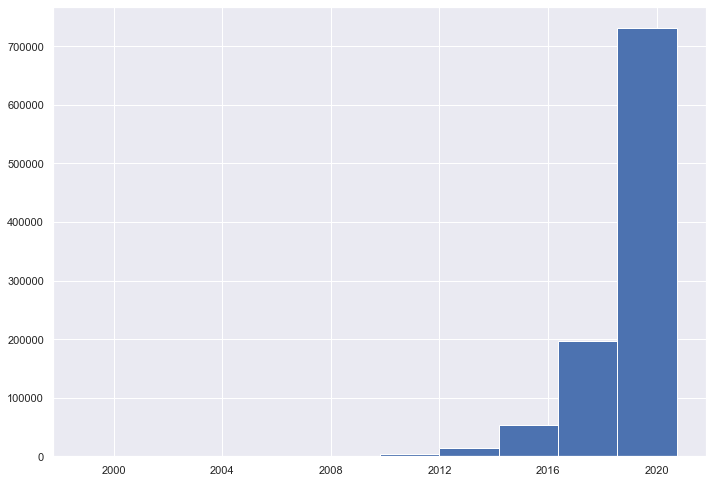

In [78]:
reg_df['reg_dt'].hist()

In [79]:
reg_df.reg_dt.dt.year.value_counts()

2020    354963
2019    291102
2018    159729
2017     87645
2016     48187
2015     26344
2014     14455
2013      7932
2012      4361
2011      2385
2010      1308
2009       718
2008       394
2007       216
2006       119
2005        65
2004        35
2003        20
2002        10
2001         6
2000         4
1999         1
1998         1
Name: reg_dt, dtype: int64

Игра практически каждый год удваивала свою аудиторию, поэтому оставим эти данные в покое и вернёмся к изначальному заданию.

In [80]:
def calc_retention(reg_df,
                   auth_df, 
                   start_date=None, 
                   cohort_type='daily',
                   n=None, 
                   pivot=True,
                   rolling=False,
                   share=True,
                   exclude_zero_period=True):
    '''
        Функция принимающая два DataFrame с датами регистраций
        и заходов пользователей в формате timestamp (unix epoch). 
        Возвращает DataFrame с retention в формате:
            %/количество вернувшихся пользователей (разделены по когортам)
            на i-день/неделю/месяц в промежутке от 0-ого или 1-ого до n-дня/недели/месяца

        Параметры:
            - reg_df - DataFrame с регистрациями
                две колонки -   reg_ts (дата регистрации, unix epoch, int)
                                uid - id-пользователя (int)
            - auth_df - DataFrame с заходами
                две колонки -   auth_ts (дата захода, unix epoch, int)
                                uid - id-пользователя (int)
            - start_date - дата прихода пользователя (формат 'YYYY-MM-DD')
                в зависимости от типа когорты по умолчанию считается за 
                    30 дней или
                    15 недель или
                    12 месяцев от последней регистрации
            - cohort_type - тип когорты ('daily'/'weekly'/'monthly')
                по умолчанию дневные когорты
            - n - день/неделя/месяц возвращения клиента (int)
                в зависимости от типа когорты по умолчанию считается 
                    retention 30 дня
                    retention 15 недели
                    retention 12 месяца
            - pivot - возвращать сводную таблицу или "сырую" (True/False)
                в случае False - три следующих параметра не используются
                по умолчанию возвращается сводная таблица
            - rolling - rolling или обычный retention (True/False)
                по умолчанию обычный (False)
            - share - выбираем между количеством или долей пользователей (True/False)
                по умолчанию считаются доли вернувшихся пользователей
            - exclude_zero_period - исключать или нет 0 день/неделю/месяц (True/False)
                по умолчанию исключать, т.к. в 0 период 100% retention
    '''
    
    correct_cohort_types = {
        'daily': {
            'n_default': 30,
            'days_in_1_n': 1
        }, 
        'weekly': {
            'n_default': 15,
            'days_in_1_n': 7
        }, 
        'monthly': {
            'n_default': 12,
            'days_in_1_n': 31            
        }
    }
    
    error_msg = "Неправильный тип когорты, возможны только: 'daily', 'weekly', 'monthly'. "
    error_msg += "Ваше значение: {cohort_type}."
    
    assert cohort_type in correct_cohort_types.keys(), error_msg.format(
        cohort_type=cohort_type
    )

    reg_df = reg_df.copy()
    auth_df = auth_df.copy()

    seconds_in_day = 24 * 60 * 60
    retention_type = f'{cohort_type}_retention'
    
    if not n:
        n = correct_cohort_types[cohort_type]['n_default']
    days_in_1_n = correct_cohort_types[cohort_type]['days_in_1_n']
    
    # считаем начальную дату
    if not start_date:
        start_date = reg_df.reg_ts.max() - (n * days_in_1_n * seconds_in_day)
        # переводим ts в datetime
        start_date = dt.datetime.fromtimestamp(start_date)
        # обнуляем часы у даты
        start_date = dt.datetime(year=start_date.year, month=start_date.month,
                                 day=start_date.day, hour=0, second=0)
        if cohort_type == 'weekly':
            # ищем дату понедельника в неделе текущей даты
            start_date -= dt.timedelta(days=start_date.weekday())
        elif cohort_type == 'monthly':
            # первое число месяца текущей даты
            start_date = start_date - dt.timedelta(days=start_date.day - 1)
        start_date = str(start_date.date())
    # возвращаем в формат ts
    start_date = int(
        (dt.datetime.strptime(start_date, '%Y-%m-%d') - dt.datetime(1970, 1, 1))
        .total_seconds()
    )
    
    if rolling:
        # убираем лишние заходы в случае подсчёта rolling retention
        auth_df = auth_df.groupby('uid').auth_ts.max().reset_index()
        retention_type = f'rolling_{retention_type}'

    # сокращаем полученные DataFrame'ы
    auth_df = auth_df.query('auth_ts >= @start_date')
    reg_df = reg_df.query('reg_ts >= @start_date')
    
    # начинаем работать с итоговой таблицей
    retention_df = reg_df.merge(
        auth_df,
        how='left'
    )
    
    # разбиваем пользователей по когортам выбранного типа
    if cohort_type == 'daily':
        # убираем часы из даты
        retention_df = retention_df.assign(
            cohort=pd.to_datetime(retention_df.reg_ts, unit='s').dt.floor('d')
        )
    elif cohort_type == 'weekly':
        # объединяем в когорты по первому дню недели
        retention_df = retention_df.assign(
            cohort=pd.to_datetime(retention_df['reg_ts'], unit='s')
            .dt.floor('d') - pd.to_datetime(retention_df['reg_ts'], unit='s')
            .dt.floor('d')
            .dt.weekday * np.timedelta64(1, 'D')
        )
    else:
        # объединяем в когорты по первому дню месяца
        retention_df = retention_df.assign(
            cohort=pd.to_datetime(retention_df['reg_ts'], unit='s')
            .dt.floor('d')
            .to_numpy()
            .astype('datetime64[M]')
        )

    # считаем retention
    retention_df[retention_type] = (
        retention_df.auth_ts - retention_df.reg_ts
    ) // (days_in_1_n * seconds_in_day)
    retention_df = retention_df.drop(columns=['reg_ts', 'auth_ts'])
    # ограничиваем по выбранному количеству дней/недель/месяцев прихода пользователя
    retention_df = retention_df.query(f'{retention_type} <= @n').reset_index(drop=True)

    if not pivot:
        return retention_df
    
    if rolling:
        # добавляем по колонке для каждого n
        for R_ in range(n + 1):
            retention_df[R_] = np.where(
                retention_df[retention_type] >= R_,
                1,
                0
            )
        # формируем итоговую, по сути сводную таблицу
        retention_df = retention_df.drop(
            columns=['uid', retention_type]
        ).groupby('cohort').sum(
        ).replace({0: np.nan})
    else:
        # создаём сводную, итоговую таблицу
        retention_df = retention_df.pivot_table(
            index='cohort', 
            columns=retention_type, 
            values='uid',
            aggfunc='nunique'
        )
    
    if share:
        # считаем вернувшихся пользователей относительно количеству пользователей в когорте
        for column in retention_df.columns[1:]:
            retention_df[column] = (
                retention_df[column] / retention_df[0]
            )
        retention_df[0] = 1.0
    
    if exclude_zero_period:
        # вычитаем нулевой день, в котором retention = 100%
        retention_df = retention_df.drop(columns=[0])[:-1]
        
    # преобразуем индекс в формат str(date) вместо datetime (убираем часы 00:00:00)
    retention_df.index = retention_df.index.astype(str)
    
    return retention_df


# большая часть функции позаимствована из урока 9.4
def format_retention(retention_df, share=True):
    '''
        Принимает таблицу, полученной с помощью функции calc_retention.
        Возвращает её же с условным форматированием.
        Чем больше значение - тем темнее её ячейка и наоборот.
        Параметры:
            - retention_df - DataFrame полученный из функции calc_retention
            - share - опция для форматирования таблицы с долями (True/False)
    '''
    
    formatter = '{:.2%}' if share else '{:.0f}'
    ur_style = (retention_df
                .style
                .set_caption('User retention by cohort')  # добавляем подпись
                .background_gradient(cmap='YlGn', axis=None)  # раскрашиваем ячейки
                .highlight_null('white')  # делаем белый фон для значений NaN
                .format(formatter, na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту

    return ur_style

In [81]:
reg_csv_path = '/home/jupyter-r.huretski-16/shared/problem1-reg_data.csv'
auth_csv_path = '/home/jupyter-r.huretski-16/shared/problem1-auth_data.csv'
reg_df = pd.read_csv(reg_csv_path, sep=';')
auth_df = pd.read_csv(auth_csv_path, sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-r.huretski-16/shared/problem1-reg_data.csv'

In [82]:
format_retention(calc_retention(reg_df, auth_df))

daily_retention,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-24,4.09%,4.09%,4.41%,5.94%,6.39%,8.12%,4.15%,5.18%,5.24%,5.18%,6.07%,5.05%,5.11%,4.54%,4.79%,4.28%,4.47%,4.54%,4.60%,3.71%,3.77%,3.71%,3.51%,3.90%,3.19%,3.32%,3.45%,2.11%,2.68%,0.38%
2020-08-25,4.34%,3.83%,5.68%,5.42%,5.42%,6.76%,4.02%,4.47%,6.32%,4.21%,4.02%,5.23%,4.15%,4.79%,4.85%,4.08%,3.89%,3.96%,4.28%,3.19%,3.83%,3.32%,3.51%,3.77%,3.57%,2.87%,2.87%,3.25%,0.70%,
2020-08-26,3.12%,3.82%,4.20%,5.67%,6.56%,7.39%,3.50%,5.54%,3.69%,5.16%,5.29%,4.97%,4.01%,4.14%,3.69%,4.39%,3.82%,4.20%,4.01%,2.99%,3.25%,3.31%,3.63%,2.61%,3.25%,2.10%,2.80%,0.45%,,
2020-08-27,3.18%,4.32%,5.09%,5.34%,5.47%,6.99%,4.20%,4.77%,5.59%,5.02%,5.40%,4.64%,4.20%,4.64%,4.77%,3.88%,4.26%,4.13%,3.24%,3.94%,4.13%,2.92%,3.18%,3.88%,2.86%,2.48%,0.38%,,,
2020-08-28,4.19%,5.27%,4.51%,5.14%,7.17%,6.48%,4.44%,5.40%,5.27%,4.70%,5.08%,5.14%,4.44%,4.89%,4.44%,5.52%,4.44%,4.44%,4.00%,4.25%,4.70%,4.57%,3.24%,3.43%,3.43%,0.76%,,,,
2020-08-29,4.63%,3.87%,5.32%,5.01%,7.16%,6.59%,4.44%,5.70%,5.01%,4.37%,5.64%,5.45%,5.01%,5.13%,4.63%,4.25%,4.56%,3.93%,3.74%,4.44%,4.25%,4.06%,2.85%,3.42%,0.51%,,,,,
2020-08-30,2.91%,3.99%,4.49%,5.89%,6.39%,6.77%,4.62%,4.24%,4.62%,5.00%,5.00%,4.56%,4.56%,4.43%,3.48%,3.73%,4.68%,3.92%,3.73%,3.80%,3.61%,4.24%,3.16%,0.44%,,,,,,
2020-08-31,3.73%,3.66%,4.74%,5.56%,7.58%,7.26%,4.61%,5.37%,4.74%,5.94%,4.42%,5.05%,4.04%,5.05%,4.04%,4.86%,3.85%,3.66%,4.30%,3.66%,3.35%,2.65%,0.51%,,,,,,,
2020-09-01,3.40%,4.98%,4.85%,5.17%,5.23%,7.88%,4.04%,4.92%,4.73%,6.12%,4.98%,4.85%,4.73%,4.41%,4.41%,5.04%,4.29%,4.73%,3.15%,4.04%,3.40%,0.50%,,,,,,,,


In [83]:
format_retention(calc_retention(reg_df, auth_df, cohort_type='weekly'))

weekly_retention,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cohort,,,,,,,,,,,,,,,
2020-06-08,21.13%,17.90%,14.20%,10.99%,7.89%,5.71%,4.92%,4.78%,4.77%,4.77%,4.77%,4.77%,4.77%,4.43%,0.66%
2020-06-15,21.17%,17.94%,14.70%,11.28%,8.13%,5.69%,4.83%,4.76%,4.76%,4.76%,4.76%,4.76%,4.39%,0.60%,
2020-06-22,21.47%,18.36%,15.10%,11.94%,8.61%,6.24%,5.31%,5.21%,5.20%,5.20%,5.20%,4.80%,0.62%,,
2020-06-29,22.03%,18.70%,15.19%,11.75%,8.69%,6.12%,5.27%,5.20%,5.20%,5.20%,4.67%,0.48%,,,
2020-07-06,21.83%,18.51%,15.31%,11.58%,8.66%,6.21%,5.31%,5.20%,5.19%,4.76%,0.59%,,,,
2020-07-13,21.43%,18.23%,14.71%,11.56%,8.04%,5.70%,5.06%,4.91%,4.45%,0.63%,,,,,
2020-07-20,21.68%,18.34%,14.81%,11.48%,8.25%,5.61%,4.77%,4.15%,0.54%,,,,,,
2020-07-27,20.55%,17.30%,14.07%,11.09%,7.96%,5.59%,4.43%,0.58%,,,,,,,
2020-08-03,21.21%,18.19%,14.81%,11.47%,8.22%,5.33%,0.55%,,,,,,,,


In [84]:
format_retention(calc_retention(reg_df, auth_df, cohort_type='monthly'))

monthly_retention,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2019-09-01,10.07%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,2.43%
2019-10-01,10.05%,5.09%,5.09%,5.09%,5.09%,5.09%,5.09%,5.09%,5.09%,5.09%,2.40%,
2019-11-01,10.01%,4.86%,4.86%,4.86%,4.86%,4.86%,4.86%,4.86%,4.86%,2.55%,,
2019-12-01,10.21%,5.12%,5.12%,5.12%,5.12%,5.12%,5.12%,5.12%,2.69%,,,
2020-01-01,9.85%,5.01%,5.01%,5.01%,5.01%,5.01%,5.01%,2.68%,,,,
2020-02-01,9.86%,4.92%,4.92%,4.92%,4.92%,4.92%,2.74%,,,,,
2020-03-01,10.06%,5.12%,5.12%,5.12%,5.12%,3.03%,,,,,,
2020-04-01,10.21%,5.11%,5.11%,5.11%,3.05%,,,,,,,
2020-05-01,10.28%,5.13%,5.13%,3.20%,,,,,,,,


In [85]:
format_retention(
    calc_retention(
        reg_df,
        auth_df,
        cohort_type='monthly',
        start_date='2018-01-01',
        n=48
    )
)

monthly_retention,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,9.82%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.81%,4.79%,0.29%
2018-02-01,10.01%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,0.38%,
2018-03-01,10.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,5.10%,0.76%,,
2018-04-01,10.06%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,5.29%,0.83%,,,
2018-05-01,10.44%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,5.11%,1.12%,,,,
2018-06-01,10.26%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,5.24%,1.07%,,,,,
2018-07-01,9.90%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,4.79%,1.02%,,,,,,
2018-08-01,9.80%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,4.87%,1.17%,,,,,,,
2018-09-01,9.64%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,5.00%,1.26%,,,,,,,,


In [86]:
format_retention(
    calc_retention(
        reg_df, 
        auth_df, 
        start_date='2020-06-22', 
        n=150
    )
)

Если смотреть на retention по неделям/месяцам, то увидим любопытную закономерность - после второго месяца/девятой недели в приложении остаётся один и тот же процент пользователей. Могу допустить, что это создающиеся каждый месяц боты, а само приложение не подразумевает долгое использование игры - реальные игроки отваливаются после двух месяцев (нулевого и первого). Интересно, что retention резко вырастает к 6 (7) дню - возможно игрокам даётся какой-либо бонус на 7 день после регистрации, после чего интерес у игроков постепенно угасает.

Посмотрим на клиентов, которые продолжают пользоваться приложением со второго месяца.

In [87]:
retention_df = calc_retention(reg_df,
                              auth_df,
                              cohort_type='monthly',
                              pivot=False)

In [88]:
retention_df.head()

,uid,reg_dt,auth_dt,cohort,monthly_retention
0,585920,2019-09-01 00:00:53,2019-09-01 00:00:53,2019-09-01,0
1,585920,2019-09-01 00:00:53,2019-09-04 21:53:12,2019-09-01,0
2,585920,2019-09-01 00:00:53,2019-09-07 23:24:41,2019-09-01,0
3,585920,2019-09-01 00:00:53,2019-09-10 13:04:36,2019-09-01,0
4,585920,2019-09-01 00:00:53,2019-09-17 05:19:34,2019-09-01,0


Посмотрим на распределение заходов пользователей:

<AxesSubplot:>

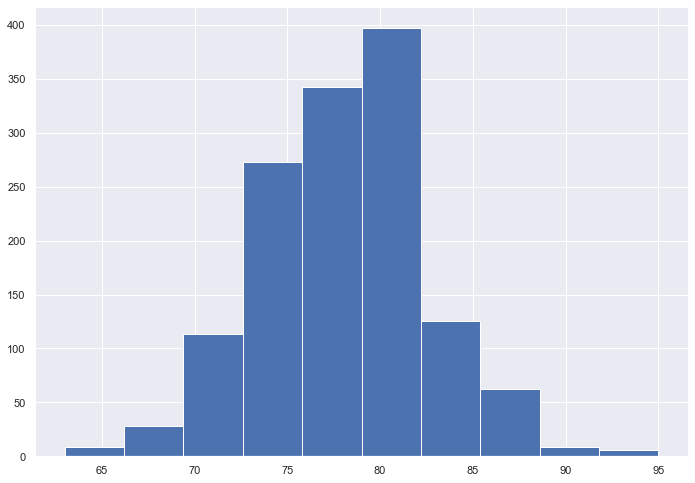

In [89]:
retention_df.assign(
    count_column=1
).query(
    'cohort == "2019-09-01" and monthly_retention >= 2'
).groupby(
    ['uid', 'cohort', 'monthly_retention'],
    as_index=False
).count().groupby(
    'uid', 
    as_index=False
).count_column.sum().count_column.hist()

Возьмём когорту побольше:

In [90]:
retention_df = calc_retention(reg_df,
                              auth_df,
                              cohort_type='monthly',
                              start_date='2018-01-01',
                              n=48,
                              pivot=False)

<AxesSubplot:xlabel='count_column', ylabel='Count'>

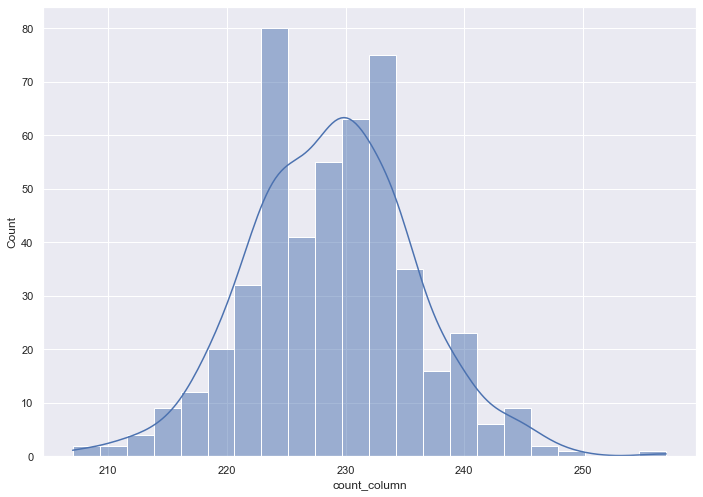

In [91]:
sns.histplot(
    data=(
        retention_df
        .assign(count_column=1)
        .query('cohort == "2018-01-01" and monthly_retention >= 2')
        .groupby(['uid', 'cohort', 'monthly_retention'], as_index=False)
        .count()
        .groupby(
            'uid', 
            as_index=False
        ).count_column
        .sum()
        .count_column), 
    kde=True
)

На всякий случай проверим те же данные по дневным когортам - возможно функция неправильно агрегирует данные по неделям/месяцам?

In [92]:
daily_retention_df = calc_retention(
    reg_df,
    auth_df,
    start_date='2018-01-01',
    n=1500,
    pivot=False
)

In [93]:
daily_retention_df.head()

,uid,reg_dt,auth_dt,cohort,daily_retention
0,215663,2018-01-01 00:02:08,2018-01-01 00:02:08,2018-01-01,0
1,215663,2018-01-01 00:02:08,2018-01-07 20:03:46,2018-01-01,6
2,215663,2018-01-01 00:02:08,2018-01-11 17:01:02,2018-01-01,10
3,215663,2018-01-01 00:02:08,2018-01-16 04:43:59,2018-01-01,15
4,215663,2018-01-01 00:02:08,2018-01-21 06:24:09,2018-01-01,20


<AxesSubplot:xlabel='count_column', ylabel='Count'>

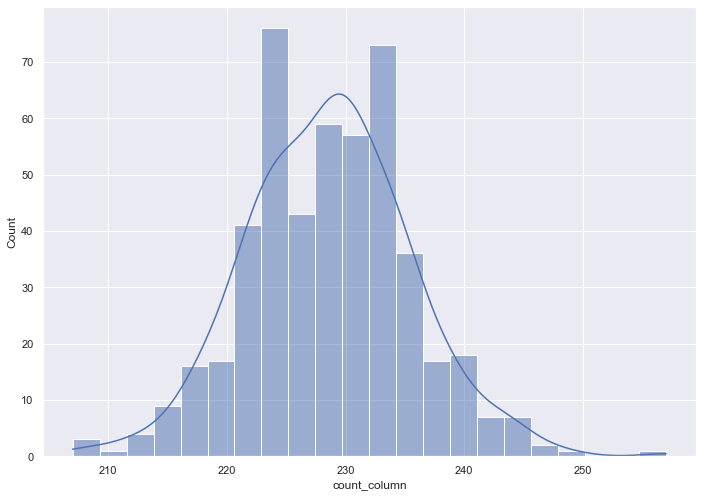

In [94]:
sns.histplot(
    data=(
        daily_retention_df
        .assign(count_column=1)
        .query('cohort >= "2018-01-01" \
        and cohort <= "2018-01-31" \
        and daily_retention >= 63')
        .groupby(['uid', 'daily_retention'], as_index=False)
        .count_column
        .count()
        .groupby(
            'uid', 
            as_index=False
        )
        .count_column
        .sum()
        .count_column
    ),
    kde=True
)

Получаем тот же самый результат.

По предварительному анализу можно сделать следующее заключение - скорее всего мы имеем дело либо с ботами (можно проверить источник трафика "вечных" пользователей), либо с таким составленным заданием, где данные были сгенерированы подобным образом с правилом вроде "продолжать заходить в приложение после 9 недели небольшой доле (около 5%) пользователей". На этом перестану мучать полученный датасет и перейду к следующему заданию. :)

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

## Решение:

Делаем первичный анализ данных:

In [95]:
ab_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';') 
# читаем данные с Яндекс Диска

In [96]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [97]:
ab_df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [98]:
ab_df.describe(include='all')

,user_id,revenue,testgroup
count,404770.000000,404770.000000,404770
unique,NaN,NaN,2
top,NaN,NaN,b
freq,NaN,NaN,202667
mean,202385.500000,26.083435,NaN
std,116847.178567,681.652928,NaN
min,1.000000,0.000000,NaN
25%,101193.250000,0.000000,NaN
50%,202385.500000,0.000000,NaN
75%,303577.750000,0.000000,NaN


Выясним какая из групп контрольная, т.к. в описании она не указана.

In [99]:
ab_df.groupby('testgroup').revenue.mean()

testgroup
a    25.413720
b    26.751287
Name: revenue, dtype: float64

Вывод - группа a - контрольная. Переименуем значения групп на более понятные.

In [100]:
ab_df = ab_df.replace({'testgroup': {'a': 'control', 'b': 'test'}})

<AxesSubplot:xlabel='revenue', ylabel='Count'>

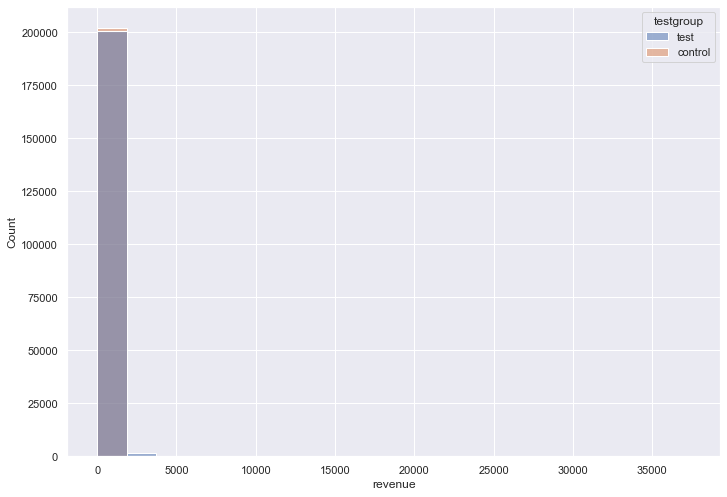

In [101]:
sns.histplot(data=ab_df, x='revenue', hue='testgroup')

<AxesSubplot:xlabel='revenue', ylabel='Count'>

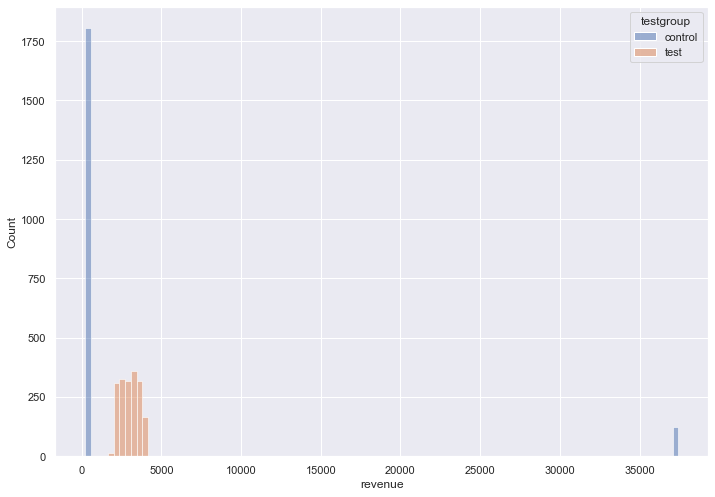

In [102]:
sns.histplot(data=ab_df.query('revenue > 0'), x='revenue', hue='testgroup')

Уже по этому графику можно предположить допущенную при составлении выборок ошибку - а именно смещённые выборки. На графике мы видим, что в контрольной группе среди платящих клиентов выделяются два сегмента - условные "киты" и "карпы". В тестовой же группе мы наблюдаем единый сегмент, в котором отсутствуют "киты". Другой вариант - сам тест мог убрать возможность/целесообразность быть "китом", скажем, перейти на подписочную модель монетизации, таким образом потенциальные "киты" в тестовой группе состоят либо в неплатящих, либо в "карпах". Помимо этого стоит и проверить наличие багов, возможно большие транзакции происходили по ошибке, пусть это и маловероятно, т.к. крупные покупки совершались пользователями из контрольной группы. Изучим доходы с пользователей в зависимости от "сегмента".

In [103]:
ab_df = ab_df.assign(
    segment=np.select(
        [
            (ab_df.revenue > 0) & (ab_df.revenue < 37000),
            ab_df.revenue >= 37000
        ],
        [
            'paying',
            'whale'
        ],
        default='not paying'
    ),
    paying=np.where(
        ab_df.revenue > 0,
        1,
        0
    )
)

In [104]:
ab_df.groupby(['testgroup', 'segment']).revenue.sum()

testgroup  segment   
control    not paying          0
           paying         545937
           whale         4590252
test       not paying          0
           paying        5421603
Name: revenue, dtype: int64

In [105]:
ab_df.groupby(['testgroup', 'segment']).revenue.count()

testgroup  segment   
control    not paying    200175
           paying          1805
           whale            123
test       not paying    200862
           paying          1805
Name: revenue, dtype: int64

In [106]:
ab_df.query('segment != "whale"').groupby('testgroup').revenue.mean()

testgroup
control     2.702926
test       26.751287
Name: revenue, dtype: float64

In [107]:
ab_df.query('segment == "paying"').groupby('testgroup').revenue.mean()

testgroup
control     302.458172
test       3003.658172
Name: revenue, dtype: float64

Мы видим, что в тестовой группе ~6% платящих пользователей приносят ~89% дохода. Нормальная ли это ситуация? В целом, для сегмента условно-бесплатных мобильных игр, да, в большинстве случаев бОльшую часть доходов приносят именно "киты". Но что ещё интереснее - в тесте и в контроле сегмент "карпов" оказался одинаковый - около 0.9% от всех пользователей, что может подтвердить гипотезу о том, что тест убрал сегмент "китов", при этом значительно увеличив средний доход с "карпов". Тем не менее, сказать о статистической значимости разниц между "карповскими" сегментами мы не можем, т.к. если бы это сравнение изначально закладывалось в тест, то в выборках не должны были бы присутствовать "киты" (при этом в тестовой группе они могли остаться в сегментах "карпов" и неплатящих). Сравнивая сегменты в полученном тесте мы сталкиваемся с проблемой подглядывания (меняем условия оценки тестирования после тестирования), хотя если бы потенциальные "киты" были бы размечены в обеих группах (например с помощью скоринга) - то можно было бы устроить множественное сравнение, провести анализ конверсии в "кита" и прочее.

Посмотрим на каждый из сегментов в отдельности. Начнём с контроля.

<AxesSubplot:xlabel='revenue', ylabel='Count'>

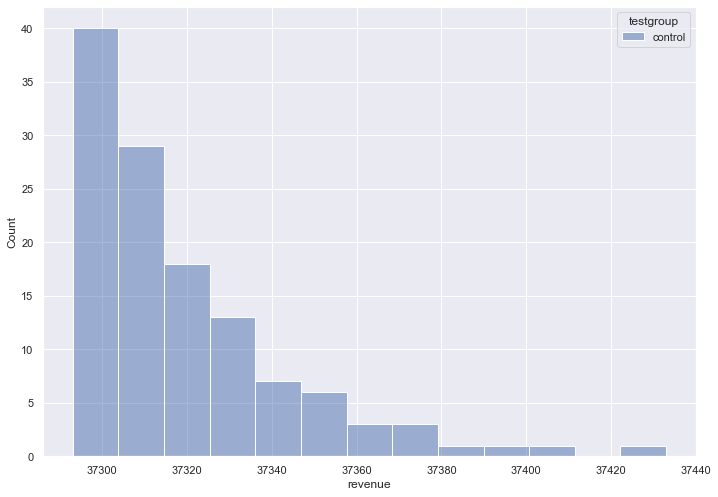

In [108]:
sns.histplot(data=ab_df.query('segment == "whale"'), x='revenue', hue='testgroup')

In [109]:
ab_df.query('segment == "whale"').revenue.value_counts(bins=10)

(37292.859000000004, 37307.0]    52
(37307.0, 37321.0]               30
(37321.0, 37335.0]               17
(37335.0, 37349.0]               10
(37349.0, 37363.0]                6
(37363.0, 37377.0]                3
(37377.0, 37391.0]                2
(37391.0, 37405.0]                1
(37405.0, 37419.0]                1
(37419.0, 37433.0]                1
Name: revenue, dtype: int64

Интересно, что среди "китов" большинство игроков потратили примерно одну и ту же сумму - около 37300 условных "рублей".

<AxesSubplot:xlabel='revenue', ylabel='Count'>

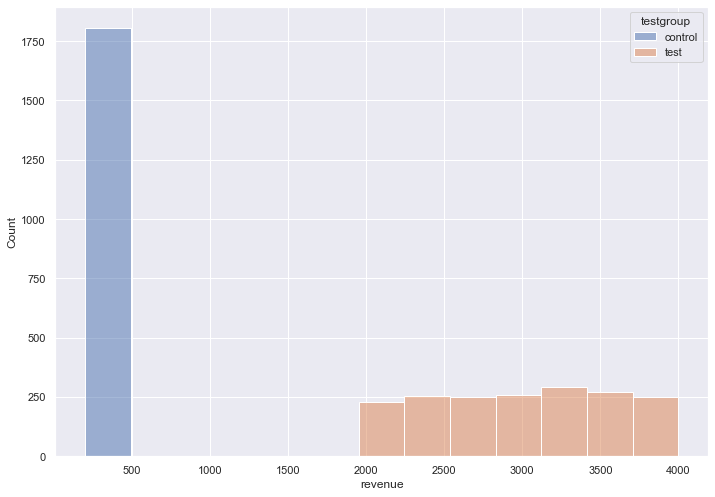

In [110]:
sns.histplot(data=ab_df.query('segment == "paying"'), x='revenue', hue='testgroup')

<AxesSubplot:xlabel='revenue', ylabel='Count'>

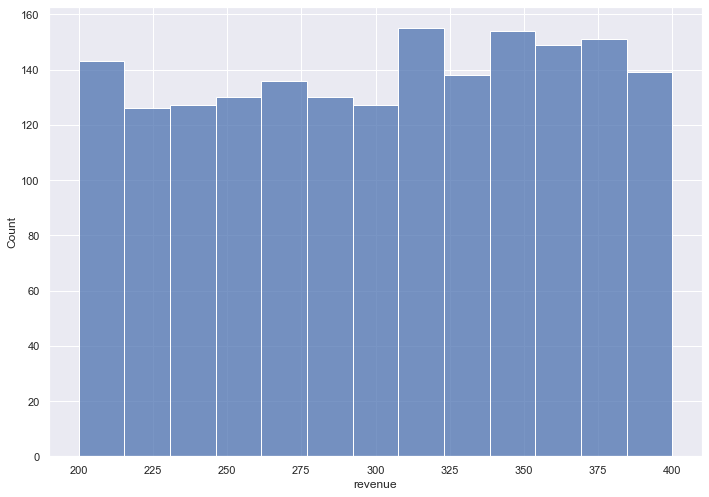

In [111]:
sns.histplot(data=ab_df.query('segment == "paying" and testgroup == "control"'), x='revenue')

In [112]:
ab_df.query('segment == "paying" and testgroup == "control"').revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

<AxesSubplot:xlabel='revenue', ylabel='Count'>

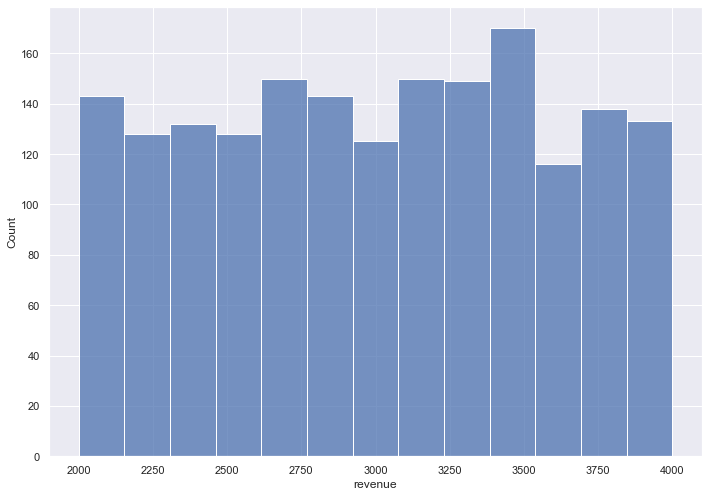

In [113]:
sns.histplot(data=ab_df.query('segment == "paying" and testgroup == "test"'), x='revenue')

In [114]:
ab_df.query('segment == "paying" and testgroup == "test"').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Сегменты "платящих" (исключая "китов" из контроля) имеют строгие рамки дохода с пользователя - от 200 до 400 в контрольной группе и от 2000 до 4000 в тесте. Распределения равномерные (отсутствует выраженная/выраженные моды), их нормальность исключена (при необходимости можно было бы воспользоваться тестом Шапиро-Уилка (shapiro из пакета scipy.stats).

Хотелось бы посмотреть на распределение дохода с пользователя в зависимости от даты регистрации/даты платежа, однако полученные наборы данных таких параметров не имеют. Однако, если допустить, что user_id распределялся поочерёдно, то мы можем посмотреть на доход в зависимости от прихода пользователя. Учитывая прошлые вероятные ошибки, возможно и здесь мы сможем найти какие-то выделяющиеся сегменты.

<AxesSubplot:xlabel='user_id', ylabel='revenue'>

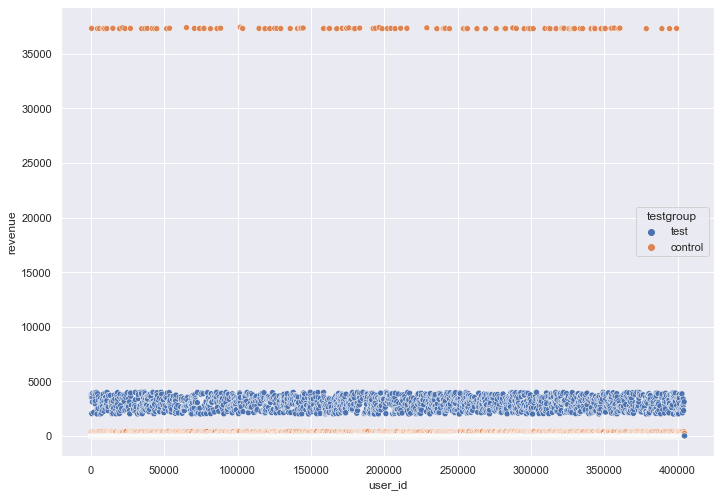

In [115]:
sns.scatterplot(data=ab_df, x='user_id', y='revenue', hue='testgroup')

Может показаться, что у тестовой группы в конце выделяются неплатящие пользователи. Скорее всего это особенности визуализации с таким количеством данных, но можно на всякий случай сравнить конверсии и средний доход с пользователя из 95 перцентиля.

In [116]:
fifth_percentile_id = int(ab_df.query('testgroup == "test"').user_id.quantile(q=0.95))

In [117]:
ab_df.query('user_id >= @fifth_percentile_id and testgroup == "test"').segment.value_counts(normalize=True)

not paying    0.990428
paying        0.009572
Name: segment, dtype: float64

In [118]:
ab_df.query('user_id < @fifth_percentile_id and testgroup == "test"').segment.value_counts(normalize=True)

not paying    0.991129
paying        0.008871
Name: segment, dtype: float64

In [119]:
ab_df.query('user_id >= @fifth_percentile_id and testgroup == "test"').groupby('segment').revenue.mean()

segment
not paying       0.000000
paying        3030.958763
Name: revenue, dtype: float64

In [120]:
ab_df.query('user_id < @fifth_percentile_id and testgroup == "test"').groupby('segment').revenue.mean()

segment
not paying       0.000000
paying        3002.107728
Name: revenue, dtype: float64

Пользователи из тестовой группы в 95 перцентиле платят и конвертируются в платящих так же, как и остальные пользователи из тестовой группы.

Т.к. данные распределены ненормально, мы воспользуемся bootstrap. Помимо него мы могли бы применить непараметрический U-критерий, однако он слишком сложен в интерпретации и имеет [ряд других недостатков](https://habr.com/ru/company/avito/blog/571094/) (в статье перечислены и приведены примеры недостатков критерия).

Тестировать мы будем следующие метрики - **конверсия в платящего**, **ARPU** и **ARPPU**. Для других метрик (Retention/average check и т.п.) полученных данных недостаточно.

In [121]:


# функция позаимствована с karpov.courses (а там позаимствовано с expf)

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() < quants.iloc[0][0] or bar.get_x() > quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}


def short_bs_summary(data_column_1, data_column_2):
    mean_diff = data_column_1.mean() - data_column_2.mean()
    bs = get_bootstrap(data_column_1, data_column_2)
    
    print(f'Разница между средними: {round(mean_diff, 3)}')
    print(f'p-value: {bs["p_value"].round(2) * 100}%')
    quant_025 = round(bs['quants'][0].min(), 3)
    quant_975 = round(bs['quants'][0].max(), 3)
    print(f'Доверительный интервал: [{quant_025}:{quant_975}]')
    print('Вывод:')
    if bs['p_value'] > 0.05:
        print('Принимаем нулевую гипотезу, разница между показателями не имеет статистическую значимость.')
        return
    print('Отвергаем нулевую гипотезу, разница между показателями имеет статистическую значимость.')
    return

In [122]:
ab_df.head()

,user_id,revenue,testgroup,segment,paying
0,1,0,test,not paying,0
1,2,0,control,not paying,0
2,3,0,control,not paying,0
3,4,0,test,not paying,0
4,5,0,test,not paying,0


In [123]:
test_df = ab_df.query('testgroup == "test"')
test_paying = test_df.paying
test_revenue = test_df.revenue
test_revenue_paying = test_df.query('paying == 1').revenue

control_df = ab_df.query('testgroup == "control"')
control_paying = control_df.paying
control_revenue = control_df.revenue
control_revenue_paying = control_df.query('paying == 1').revenue

  0%|          | 0/1000 [00:00<?, ?it/s]

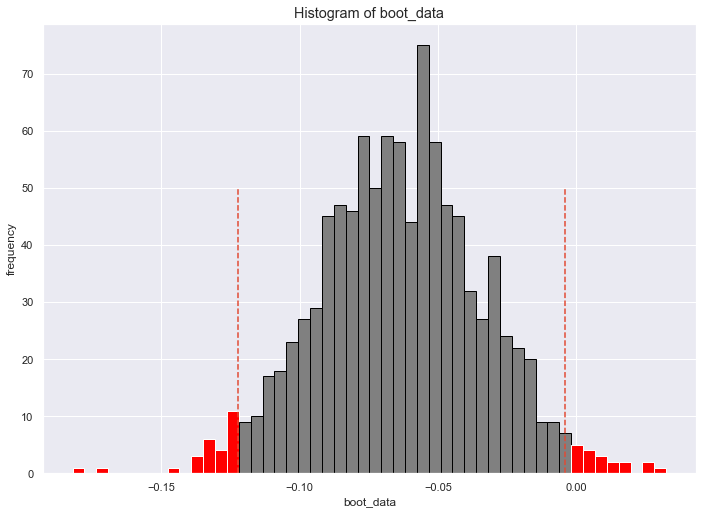

Разница между средними: -0.063
p-value: 3.0%
Доверительный интервал: [-0.122:-0.004]
Вывод:
Отвергаем нулевую гипотезу, разница между показателями имеет статистическую значимость.


In [124]:
# умножаем конверсию на 100, чтобы получить проценты
short_bs_summary(test_paying * 100, control_paying * 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

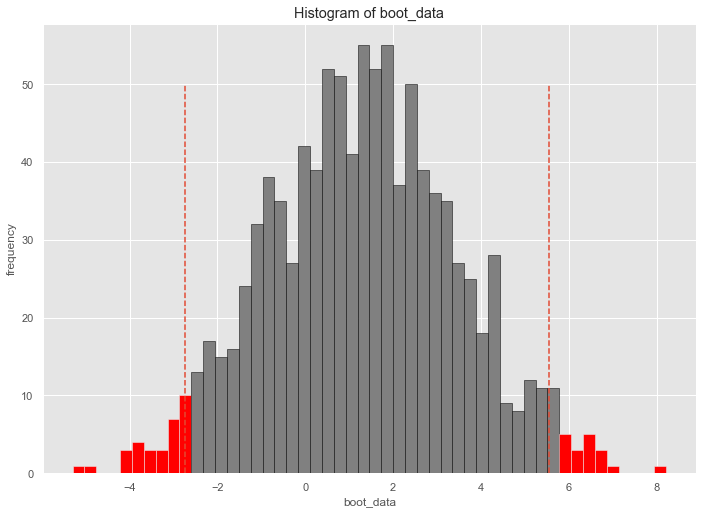

Разница между средними: 1.338
p-value: 54.0%
Доверительный интервал: [-2.749:5.547]
Вывод:
Принимаем нулевую гипотезу, разница между показателями не имеет статистическую значимость.


In [125]:
short_bs_summary(test_revenue, control_revenue)

  0%|          | 0/1000 [00:00<?, ?it/s]

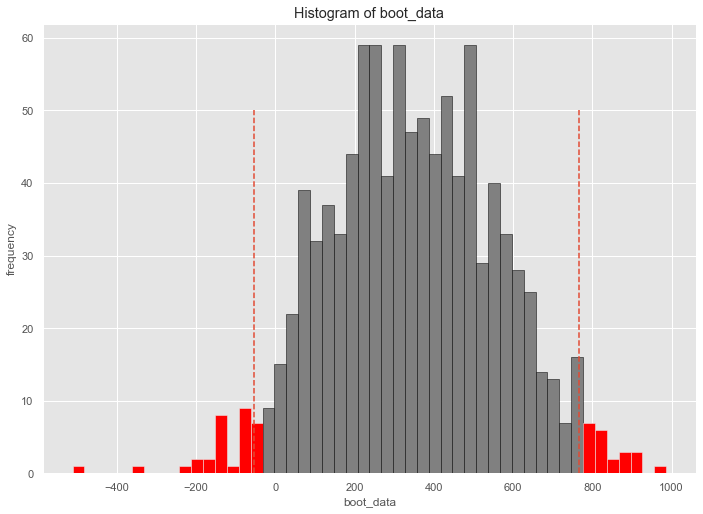

Разница между средними: 339.66
p-value: 11.0%
Доверительный интервал: [-53.615:765.855]
Вывод:
Принимаем нулевую гипотезу, разница между показателями не имеет статистическую значимость.


In [126]:
short_bs_summary(test_revenue_paying, control_revenue_paying)

Выводы по итогу анализа теста мы можем сделать следующие:

* Между группами статистически значимая разница в конверсии в платящего (в пользу контроля)
* Мы не смогли увидеть статистическую разницу в среднем доходе на пользователя (в т.ч. и платящего) между контрольной и тестовой группами после проведённого теста

Решение - не раскатывать тестируемую акцию на всю аудиторию.

При этом стоит отметить:

* Возможно, что выборки смещённые, т.к. невозможно обнаружить сегмент "китов" в тестовой группе, в отличие от контрольной
* Возможно, что новая акция убирает смысл вкладывать большие деньги в игру, таким образом все потенциальные "киты" в тестовой группе могли распределиться по другим сегментам

Учитывая, что "киты" есть в контрольной группе - то даже при наличии статистической значимых улучшений ARPU/ARPPU в пользу тестовой группы, раскатывать акцию на всех пользователей слишком рисковано, т.к. это может кардинально поменять источники дохода. Возможно, разумнее было бы провести новый тест с выделением сегмента "китов" и, соответственно, другими предложениями для такого сегмента в тестовой группе. Помимо этого важно посмотреть показатель retention, вполне возможно, что нынешние "киты" единожды вкладывают крупную сумму и в результате в долгосрочной перспективе будут приносить меньше доходов в сравнении с другими сегментами, возможно такие крупные вложения делают игру для них слишком простой, из-за чего они могут быстро терять интерес к игре.

## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Решение:
Имея такую формулировку задачи я бы опирался в первую очередь на те метрики, на которые влияет акция. Предположим, что игра условно-бесплатная, игрок имеет возможность совершать внутреигровые покупки за реальные деньги. Предположим, что уникальные предметы уникальны во время каждой отдельной акции, дополнительные монеты и бонусы доступны для преобретения внутри игры. 

В таком случае необходимо замерить **спрос на другие/аналогичные уникальные предметы**, **дополнительные монеты** и **бонусы**, а заодно посмотреть на **изменения в "продуктовой корзине"** пользователя. Помимо спроса стоит следить за основными верхнеуровневыми метриками - **Retention/ARPU/ARPPU/Paying share/Average Check/Average Session Length/LTV/DAU/WAU**. Все метрики необходимо замерять до акции, во время акции и после, до возвращения к примерно тем же показателям, которые были до акции (после акции возможно временное снижение интереса как к покупкам, так и к игре в целом).

Первая эта акция или нет, всегда есть большой смысл провести a/b тест на непересекающихся аудиториях (например взять аудитории из разных стран с похожими игроками), выделяя небольшой контроль.

Необходимо учитывать и сезонность при проведении ежемесячных ивентов, к примеру скорее всего во время выходных/праздничных дней игроки будут больше времени проводить в игре, а в день зарплаты стабильно совершать крупные покупки.

Для замерения сложности ряда уровней тематического события проще всего использовать кривую сложности - замерять сколько в среднем у игрока уходит времени (ось X) на каждый из уровней (ось Y). В зависимости от наших целей кривая сложности может иметь разную форму. Полезно посмотреть на проходимость уровней - построить воронку с процентом игроков прошедших уровни. При равномерном усложнении уровней процент игроков будет уменьшаться стабильно, однако на особенно сложных уровнях процент оставшихся игроков будет уменьшаться резко.

При изменении механики описанным образом я бы смотрел на те же самые метрики и добавил бы ещё несколько - среднее время прохождения всех уровней (для сравнения с прошлой механикой, возможно новая механика не так сильно изменит это время) и возможно посмотрел бы на самые проблемные "промежутки" уровней - если игрок часто проигрывает на определённом уровне, но продолжает пытаться дойти и пройти его снова и снова - то уровни из "промежутка" интересны (возможно из-за награждений) при каждой новой итерации.